BERTによる日本語文章分類

You can follow my Japnese NLP story [HERE!](https://medium.com/@nithikorn.lert/japanese-nlp-using-bert-part-1-tokenization-bert%E3%81%A7%E6%97%A5%E6%9C%AC%E8%AA%9E%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%E3%83%BC%E3%83%91%E3%83%BC%E3%83%881-%E3%83%88%E3%83%BC%E3%82%AF%E3%83%B3%E5%8C%96-167e7aa04a3b)

In [ ]:
%%capture
!pip install transformers
!pip install fugashi
!pip install ipadic

In [ ]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForSequenceClassification
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, random_split

MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [ ]:
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
bert_sc = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
bert_sc = bert_sc.cuda()

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [ ]:
#データのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz

#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz 

--2021-10-31 05:12:20--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  5.55MB/s    in 1.5s    

2021-10-31 05:12:22 (5.55 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



In [ ]:
category_list = os.listdir("/content/text/")
category_list 

['CHANGES.txt',
 'kaden-channel',
 'peachy',
 'it-life-hack',
 'livedoor-homme',
 'smax',
 'sports-watch',
 'dokujo-tsushin',
 'movie-enter',
 'topic-news',
 'README.txt']

In [ ]:
# トークナイザのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# 例のファイルを見ようよ。
ex_txt = open("/content/text/dokujo-tsushin/dokujo-tsushin-4778030.txt").read().replace("\u3000", "").split("\n")
ex_txt[0:10]

['http://news.livedoor.com/article/detail/4778030/',
 '2010-05-22T14:30:00+0900',
 '友人代表のスピーチ、独女はどうこなしている？',
 'もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。',
 '',
 '「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」',
 '',
 'さてそんなとき、独女はどう対応したらいいか？',
 '',
 '最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。']

In [ ]:
 ex_txt[2:10] # なんとなく、最初の論文は関係のないテキストがあるืので、3行目から保ちます。PyhtonのListには0から始まるので注意ください。

['友人代表のスピーチ、独女はどうこなしている？',
 'もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。',
 '',
 '「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」',
 '',
 'さてそんなとき、独女はどう対応したらいいか？',
 '',
 '最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。']

In [ ]:
# BERTにはこう言うデータが好きです。
" ".join( ex_txt[2:10] )

'友人代表のスピーチ、独女はどうこなしている？ もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。  「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」  さてそんなとき、独女はどう対応したらいいか？  最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。'

In [ ]:
category_lst = [folder for folder in os.listdir('/content/text/') if not folder.endswith(".txt")]
category_lst

['kaden-channel',
 'peachy',
 'it-life-hack',
 'livedoor-homme',
 'smax',
 'sports-watch',
 'dokujo-tsushin',
 'movie-enter',
 'topic-news']

In [ ]:
all_content = []
for label, folder_name in enumerate(category_lst):
    directory = '/content/text/' + folder_name + "/"
    print(directory)
    for filename in os.listdir(directory):
        txt = open(directory + filename).read().replace("\u3000", "").splitlines()[2:]
        all_content.append(txt)

/content/text/kaden-channel/
/content/text/peachy/
/content/text/it-life-hack/
/content/text/livedoor-homme/
/content/text/smax/
/content/text/sports-watch/
/content/text/dokujo-tsushin/
/content/text/movie-enter/
/content/text/topic-news/


In [ ]:
count_lst = []
seq_lst = [i for lst in all_content for i in lst]
for seq in seq_lst:
    count = len(seq)
    if count != 0:
        count_lst.append(count)

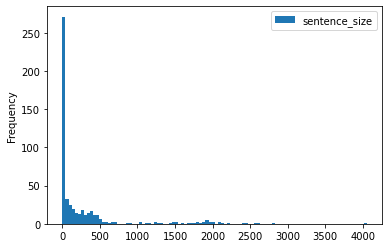

In [ ]:
count_df = pd.Series(count_lst).value_counts().to_frame()
count_df.columns = ['sentence_size']
count_df.plot.hist(bins=100)

In [ ]:
count_df.describe() # 4053 is too long and need time to train. So, in this example we choose 288 as "max_length". 

,sentence_size
count,525.000000
mean,272.630476
std,539.894336
min,1.000000
25%,4.000000
50%,36.000000
75%,288.000000
max,4053.000000


In [ ]:
seq_size = 228
category_lst = [folder for folder in os.listdir('/content/text/') if not folder.endswith(".txt")]

encode_lst = []
for label, folder_name in enumerate(category_lst):
    directory = '/content/text/' + folder_name + "/"
    # print(directory)
    for filename in os.listdir(directory):

        txt = open(directory + filename).read().replace("\u3000", "").split("\n")[2:]
        txt = " ".join(txt) 
        encode = tokenizer(txt, max_length=seq_size, padding='max_length', truncation=True)
        encode['labels'] = label
        encode = { key: torch.tensor(value) for key, value in encode.items() }
        encode_lst.append(encode)

In [ ]:
encode_lst[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 'input_ids': tensor([    2,   319, 28444, 29065, 28469,  4401,     5, 19445, 23141, 28520,
          6774,   590,    36, 25312,    23, 17836, 28687,  1108,     7,  3661,
          1317,    14,   656,   679, 30657,  9317, 29760,  9398,  9594,  4410,
         28487,    13,    15,    10, 19445,  1575,    14,  5648,    81,    18,
          4035, 28472,  4572, 28472, 28534,   992,     5,  3387,   834, 24040,
         28520, 14266,   590,    36, 25312,    23, 17836, 28687,  1108,     5,
          3661,  1317,    14,   127,    37,  8660,     

In [ ]:
# let's see a sentence of data
"".join(tokenizer.convert_ids_to_tokens(encode_lst[0]['input_ids'])).replace('##', "")

'[CLS]手のひらサイズの球体ハンディクリーナー「オーブ(ORB)」に上位モデルが登場!【売れ筋チェック】コロッとした球体デザインが印象的なブラック・アンド・デッカーのコードレスハンディクリーナー「オーブ(ORB)」の上位モデルが7月下旬に発売される。商品名は「ORB72」。吸引力が25%ほどパワーアップし、充電時間が6時間から3.5時間に短縮され、従来モデルで「イマイチ」とされていた部分を改善した。充電時の消費[SEP]'

In [ ]:
train_size = int(0.9 * len(encode_lst))
validate_size = len(encode_lst) - train_size
train_dataset, validate_dataset = random_split(encode_lst, [train_size, validate_size])

print("train_size:", train_size)
print("validate_size:", validate_size)

train_size: 6638
validate_size: 738


In [ ]:
batch_size = 20
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
%%capture
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(category_lst))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.train() 
model.to(device)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

`model.train() `   VS   ` model.eval()`

`model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.

https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)
train_loss = 0

model.train() # turn on train mode

for batch in train_dataloader:
    batch_input_ids = batch['input_ids'].to(device)
    batch_input_mask = batch['attention_mask'].to(device)
    batch_labels = batch['labels'].to(device)
    batch_tokens = batch['token_type_ids'].to(device)

    outputs = model(input_ids = batch_input_ids, 
                    token_type_ids = batch_tokens, 
                    attention_mask = batch_input_mask, 
                    labels = batch_labels)
    
    loss = outputs.loss
    loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    train_loss += loss.item()

In [ ]:
model.eval() # turn off train mode

predict_lst=[]
labels_lst = []

for batch in validate_dataloader:
    batch_input_ids = batch['input_ids'].to(device)
    batch_input_mask = batch['attention_mask'].to(device)
    batch_labels = batch['labels'].to(device)
    batch_tokens = batch['token_type_ids'].to(device)
    
    with torch.no_grad():   
        preds = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask)
        predict_lst.append(preds)
        labels_lst.append(batch['labels'])        

there are 738 articles for validation and the first 5 examples are shown below

In [ ]:
# there are 738 articles for validation
label_lst_numpy = np.concatenate( [label_batch.cpu().numpy() for label_batch in labels_lst] )
print(len(label_lst_numpy))
label_lst_numpy[0:5]

738


array([4, 6, 2, 6, 2])

In [ ]:
predict_lst_numpy = np.concatenate( [output_batch.logits.argmax(-1).cpu().numpy() for output_batch in predict_lst])
print(len(predict_lst_numpy))
predict_lst_numpy[0:5]

738


array([4, 1, 2, 6, 8])

In [ ]:
acc_df = pd.DataFrame(label_lst_numpy, columns=['label'])
acc_df['predict'] = predict_lst_numpy
acc_df['check'] = acc_df['label'] == acc_df['predict']

In [ ]:
true = acc_df[acc_df['check'] == True].shape[0]
false = acc_df[acc_df['check'] == False].shape[0]
all = acc_df.shape[0]

print(true/all)

0.9173441734417345


Ref:
1. BERTによる自然言語処理入門: Transformersを使った実践プログラミング
2. https://gist.github.com/jshirius/34624297b834ad8192c58e9b7ab636b5#file-huggingface-transformers-bert-ipynb